# CS576 Assignment #3: Object Detection Using YOLO v1
-----
Primary TA : Seungwoong Jo

TA's E-mail : jinwoo-kim@kaist.ac.kr, seongwoongjo@kaist.ac.kr, whieya@kaist.ac.kr

## Instruction
- In this assignment, you will implement, train, and test Yolo v1 on Pascal VOC Detection dataset with 20 object categories (`'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike', 'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor'`).

- For this, you need to implement (1) architecture, (2) loss function, (3) training/testing pipeline, and (4) inference function.

- In each part, you will be given a starter code for the implementation. Please read instructions carefully to implement the codes.  

- In this assignment, we will provide you with pre-trained weights of the Yolo architecture to reduce the amount of time required for the convergence and thus ease your burden on the training. This pre-trained weights will automatically loaded to your network if you implemented it correctly.

- <font color="red"> It takes at least 6 mins per epoch, so you need at least 6*50=300 mins for the whole training. So please get started as early as possible. </font> 


## Submission guidelines
- Your code and report will be all in Colab. 
- Go to the [link](https://drive.google.com/drive/folders/1Kf_dCvta0NU_VzyMat6fL6Gn-1UeME_B?usp=sharing), make a copy of `assignment3.ipynb`, `data.py`, `dataset.zip`, `test_images.zip`, and make `weights` directory into your own google drive. Find the copies in your drive, recover their names to original ones if their names were changed to e.g. `Copy of assignment3.ipynb` or `assignment3.ipynb의 사본`. Also, keep them in a single directory.
- <font color="red"> You will get the full credit **only if** you complete the code **and** write a discussion of the results in the discussion section at the bottom of this page. Please refer to the discussion section for the details. </font> 
- Also, please write discussion in <font color="red"> ENGLISH, not in Korean. </font> 
- We should be able to reproduce your results using your code. Please double-check if your code runs without error and reproduces your results. Submissions failed to run or reproduce the results will get a substantial penalty. 

## Deliverables
- Your Colab notebook with name of **[StudentID].ipynb**
- Result images (`1_result.jpg`, `2_result.jpg`, ...). Please refer to Problem 4.
- Saved checkpoint (`last.pth`). This will be saved automatically in your `checkpoints` directory. 
- Submit all of them in a format as : **[StudentID].zip**.
- **If your submission doesn't contain all of the above deliverables , you will lose a point for deliverable (5pt).**
- Your assignment should be submitted through KLMS. All other submissions (e.g., via email) will not be considered as valid submissions.


## Due date
- **23:59:59 May 19th.**
- Late submission is allowed until 23:59:59 May 21st.
- Late submission will be applied 20% penalty.

## Questions
- Please use "assignment3" channel in the SLACK channel (https://join.slack.com/t/kaist-cs576-cvhq/shared_invite/zt-15g6flwkk-lEIIBYFg8N0VRPHOsxhVrA) as a main communication channel. When you post questions, please make it public so that all students can share the information.
- When you post questions, please avoid posting your own implementation (eg, posting the capture image of your own implementation.) 

## Plagiarism
- <font color="red"> Do not copy public codes or your classmate's code. We will strictly detect the plagiarism. All codes with plagiarism will be considered as 0 point.

## Changelog

In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [ ]:
# Specify the directory path where `assignemnt3.ipynb` and `dataset.zip` exist.
# For example, if you saved `assignment3.ipynb` `/gdrive/My Drive/cs576/assignment3` directory,
# then set root = '/gdrive/My Drive/cs576/assignment3'
root = '/gdrive/My Drive/CS576_data/HW3'

!ln -s '/gdrive/My Drive'/{root.replace('/gdrive/My Drive/', '')}/weights ./
!unzip -q '/gdrive/My Drive'/{root.replace('/gdrive/My Drive/', '')}/dataset.zip
!unzip -q '/gdrive/My Drive'/{root.replace('/gdrive/My Drive/', '')}/test_images.zip

In [ ]:
import sys
sys.path.append(root)

import warnings
warnings.filterwarnings("ignore")

import os
import cv2
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision import transforms

from data import VOCDetection
def makedirs(path):
    if not os.path.exists(path):
        os.makedirs(path)

In [ ]:
# Configurations
run_name = 'vgg16'          # experiment name.
ckpt_root = 'checkpoints'   # from/to which directory to load/save checkpoints.
data_root = 'dataset'       # where the data exists.
pretrained_backbone_path = 'weights/vgg_features.pth'

device = 'cuda' if torch.cuda.is_available() else 'cpu'
lr = 0.001          # learning rate
batch_size = 64     # batch_size
last_epoch = 1      # the last training epoch. (defulat: 1)
max_epoch = 50      # maximum epoch for the training.

num_boxes = 2       # the number of boxes for each grid in Yolo v1.
num_classes = 20    # the number of classes in Pascal VOC Detection.
grid_size = 7       # 3x224x224 image is reduced to (5*num_boxes+num_classes)x7x7.
lambda_coord = 7    # weight for coordinate regression loss.
lambda_noobj = 0.5  # weight for no-objectness confidence loss.

ckpt_dir = os.path.join(root, ckpt_root)
makedirs(ckpt_dir)
!ln -s '/gdrive/My Drive'/{ckpt_dir.replace('/gdrive/My Drive/', '')} ./

In [ ]:
train_dset = VOCDetection(root=data_root, split='train')
train_dloader = DataLoader(train_dset, batch_size=batch_size, shuffle=True, drop_last=True, num_workers=8)

test_dset = VOCDetection(root=data_root, split='test')
test_dloader = DataLoader(test_dset, batch_size=batch_size, shuffle=False, drop_last=False, num_workers=8)

# Problem 1. Implement Architecture (10pt) [(Illustration)](https://docs.google.com/drawings/d/1DNWgMK0XNQJ1IZPxX3u_ger7s-iQpAHG0pI_6A5dAPs/edit?usp=sharing)

In this section, you need to implement two modularized networks for Yolo v1:

(1) Backbone network of Yolo v1, extracting feature representations ($N, 512, 7, 7$) on input images ($N, 3, 224, 224$),  
(2) Detection network of Yolo v1, predicting object confidences, classes, and their locations based on grids ($N, S, S, B\times5+C$),

where $N, S, B, C$ refer to the batch size, grid size, the number of boxes for each grid, and the number of object classes, respectively.

For more details about the network architecture, please refer to the illustration.

Below, you will be provided with a skeleton python class for Yolo.  
Please fill in the `self.features = nn.Sequential(...)` and `self.detector = nn.Sequential(...)` to implement this module.

In [ ]:
class Yolo(nn.Module):
    def __init__(self, grid_size, num_boxes, num_classes):
        super(Yolo, self).__init__()
        self.S = grid_size
        self.B = num_boxes
        self.C = num_classes
        self.features = nn.Sequential(
            # P1.1. implement VGG16 backbone network here.

            # ----- Define three layers !!! -----
            # 1) Conv2d: kernel_size 3, stride 1, padding 1
            # 2) ReLU: True
            # 3) MaxPool2d: kernel_size 2, stride 2, padding 0, dilation=1, ceil_mode=False 

            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),                            # (0)
            nn.ReLU(inplace=True),                                                           # (1)
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),                           # (2) 
            nn.ReLU(inplace=True),                                                           # (3)
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),   # (4) 
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),                          # (5)
            nn.ReLU(inplace=True),                                                           # (6)
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),                         # (7)
            nn.ReLU(inplace=True),                                                           # (8)
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),   # (9)
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),                         # (10)
            nn.ReLU(inplace=True),                                                           # (11) 
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),                         # (12)
            nn.ReLU(inplace=True),                                                           # (13)
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),                         # (14)
            nn.ReLU(inplace=True),                                                           # (15)
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),   # (16)
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),                         # (17)
            nn.ReLU(inplace=True),                                                           # (18)
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),                         # (19)
            nn.ReLU(inplace=True),                                                           # (20)
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),                         # (21)
            nn.ReLU(inplace=True),                                                           # (22)
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),   # (23)
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),                         # (24)
            nn.ReLU(inplace=True),                                                           # (25)
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),                         # (26)
            nn.ReLU(inplace=True),                                                           # (27)
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),                         # (28)
            nn.ReLU(inplace=True),                                                           # (29)
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)    # (30)
        )
        self.detector = nn.Sequential(
            # P1.2. implement detection head here.

            # ----- Define four layers !!! -----
            # 1) Linear: 512 * 7 * 7, 4096
            # 2) ReLU: True
            # 3) Dropout(p=0.5, inplace=False)
            # 4) Linear: 4096, 7 * 7 * 30 

            nn.Linear(512 * 7 * 7, 4096),          # (0)
            nn.ReLU(inplace=True),                 # (1)
            nn.Dropout(p=0.5, inplace=False),      # (2)
            nn.Linear(4096, 7 * 7 * 30)            # (3)
        )
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.detector(x)
        x = F.sigmoid(x)
        x = x.view(-1, self.S, self.S, self.B*5+self.C)
        return x

model = Yolo(grid_size, num_boxes, num_classes)
model = model.to(device)
pretrained_weights = torch.load(pretrained_backbone_path)
model.load_state_dict(pretrained_weights)

# It should print out <All keys matched successfully> when you implemented VGG correctly.

<All keys matched successfully>

In [ ]:
# Freeze the backbone network.
model.features.requires_grad_(False)
model_params = [v for v in model.parameters() if v.requires_grad is True]
optimizer = optim.SGD(model_params, lr=lr, momentum=0.9, weight_decay=5e-4)

# Load the last checkpoint if exits.
ckpt_path = os.path.join(ckpt_dir, 'last.pth') 

if os.path.exists(ckpt_path): 
    ckpt = torch.load(ckpt_path)
    model.load_state_dict(ckpt['model'])
    optimizer.load_state_dict(ckpt['optimizer'])
    last_epoch = ckpt['epoch'] + 1
    print('Last checkpoint is loaded. start_epoch:', last_epoch)
else:
    print('No checkpoint is found.')

No checkpoint is found.


# Problem 2. Implement Loss Function (15pt)

In this section, you need to implement code for computing losses in Yolo.  
Below, you will be provided with a skeleton module class, where you need to complete the forward function:  
`def forward(self, pred_tensor, target_tensor): 
...
return loss_xy, loss_wh, loss_obj, loss_noobj, loss_class`

where $N, S, B, C$ refer to the batch size, grid size, the number of boxes for each grid, and the number of object classes, respectively.

To get an easy picture on how `pred_tensor` and `target_tensor` look like, refer to the page 18~25 in [this slide](https://docs.google.com/presentation/d/1aeRvtKG21KHdD5lg6Hgyhx5rPq_ZOsGjG5rJ1HP7BbA/pub?start=false&loop=false&delayms=3000&slide=id.g137784ab86_4_1187)

Refer to the paper for more details about the loss function: https://arxiv.org/pdf/1506.02640.pdf

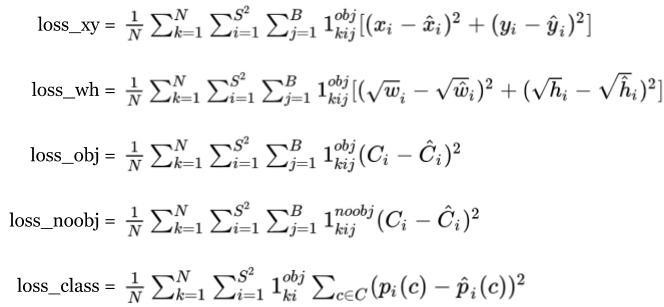

In [ ]:
import pdb

class Loss(nn.Module):
    def __init__(self, grid_size=7, num_bboxes=2, num_classes=20):
        """ Loss module for Yolo v1.
        Use grid_size, num_bboxes, num_classes information if necessary.

        Args:
            grid_size: (int) size of input grid.
            num_bboxes: (int) number of bboxes per each cell.
            num_classes: (int) number of the object classes.
        """
        super(Loss, self).__init__()
        self.S = grid_size
        self.B = num_bboxes
        self.C = num_classes

    def compute_iou(self, bbox1, bbox2):
        """ Compute the IoU (Intersection over Union) of two set of bboxes, each bbox format: [x1, y1, x2, y2].
        Use this function if necessary.

        Args:
            bbox1: (Tensor) bounding bboxes, sized [N, 4].
            bbox2: (Tensor) bounding bboxes, sized [M, 4].
        Returns:
            (Tensor) IoU, sized [N, M].
        """
        N = bbox1.size(0)
        M = bbox2.size(0)

        # Compute left-top coordinate of the intersections
        lt = torch.max(
            bbox1[:, :2].unsqueeze(1).expand(N, M, 2), # [N, 2] -> [N, 1, 2] -> [N, M, 2]
            bbox2[:, :2].unsqueeze(0).expand(N, M, 2)  # [M, 2] -> [1, M, 2] -> [N, M, 2]
        )
        # Conpute right-bottom coordinate of the intersections
        rb = torch.min(
            bbox1[:, 2:].unsqueeze(1).expand(N, M, 2), # [N, 2] -> [N, 1, 2] -> [N, M, 2]
            bbox2[:, 2:].unsqueeze(0).expand(N, M, 2)  # [M, 2] -> [1, M, 2] -> [N, M, 2]
        )
        # Compute area of the intersections from the coordinates
        wh = rb - lt   # width and height of the intersection, [N, M, 2]
        wh[wh < 0] = 0 # clip at 0
        inter = wh[:, :, 0] * wh[:, :, 1] # [N, M]

        # Compute area of the bboxes
        area1 = (bbox1[:, 2] - bbox1[:, 0]) * (bbox1[:, 3] - bbox1[:, 1]) # [N, ]
        area2 = (bbox2[:, 2] - bbox2[:, 0]) * (bbox2[:, 3] - bbox2[:, 1]) # [M, ]
        area1 = area1.unsqueeze(1).expand_as(inter) # [N, ] -> [N, 1] -> [N, M]
        area2 = area2.unsqueeze(0).expand_as(inter) # [M, ] -> [1, M] -> [N, M]

        # Compute IoU from the areas
        union = area1 + area2 - inter # [N, M, 2]
        iou = inter / union           # [N, M, 2]

        return iou

    def forward(self, pred_tensor, target_tensor):
        """ Compute loss.

        Args:
            pred_tensor (Tensor): predictions, sized [batch_size, S, S, Bx5+C], 5=len([x, y, w, h, conf]).
            target_tensor (Tensor):  targets, sized [batch_size, S, S, Bx5+C].
        Returns:
            loss_xy (Tensor): localization loss for center positions (x, y) of bboxes.
            loss_wh (Tensor): localization loss for width, height of bboxes.
            loss_obj (Tensor): objectness loss.
            loss_noobj (Tensor): no-objectness loss.
            loss_class (Tensor): classification loss.
        """
        # P2. Write your code here
        
        # ----- Defind Parameters -----
        # N: Batch size
        # self.S: Grid size  
        # self.B: the number of boxes for each grid
        # self.C: the number of object classes 

        # ----- Process ------
        # (1) Find Indicator Function
        #     - There is only one value called confidence score in GT(target_tensor) which has 1 value.
        #     - We are using above value to find object or no-object in pred_tensor 
        # (2) Change format to calculate compute_iou function
        #     - Bounding box format is [x, y, w, h] -> To change [x_left_top, y_left_top, x_right_bottom, y_right_bottom]
        #     - In compute_iou format same as [x1, y1, x2, y2] = [x_left_top, y_left_top, x_right_bottom, y_right_bottom]
        # (3) Using IoU, the we choose higher IoU values and calculate loss functions !!
        #     - Find best bounding box information 
        #     - Using above informations, finally we can calculate five losses !!!
        
        ##############################################################################################
        ######################### Same steps until split into two methods !! #########################
        ##############################################################################################

        # Define Batch Size for iterate parameter and divide calculation
        N = pred_tensor.size(dim=0)  

        # There is only conf value of GT because bbox1_conf and bbox2_conf are same !! (There is only one bounding box in GT)
        gt_bbox_conf = target_tensor[:, :, :, 4] == 1 # Output = torch.Size([64, 7, 7]): In every batch, there only True value has 1 and False have 0 of bounding box

        ##############################################################################################
        ############### METHOD 1: This method takes a lot of time to train model !!!!! ###############
        ##############################################################################################
        
        ##### To get last dim's 30 values when object in there or no-object in others 
        # obj_bbox_conf = gt_bbox_conf.unsqueeze(dim=3).expand_as(target_tensor) # Output = torch.Size([64, 7, 7, 30]): dim=4 has same bool values

        ##### Divide object tensor and no-object tensors using GT(target_tensor) confidence values !!! 
        # obj_tensor = torch.zeros(N, self.S, self.S, (5*self.B) + self.C)      # To save obj pred tensor : torch.Size([64, 7, 7, 30])
        # noobj_tensor = torch.zeros(N, self.S, self.S, (5*self.B) + self.C)    # To save no obj pred tensor : torch.Size([64, 7, 7, 30])
        # gt_obj_tensor = torch.zeros(N, self.S, self.S, (5*self.B) + self.C)   # To save obj GT tensor : torch.Size([64, 7, 7, 30])
        # gt_noobj_tensor = torch.zeros(N, self.S, self.S, (5*self.B) + self.C) # To save no obj GT tensor : torch.Size([64, 7, 7, 30])
        
        ##### The Result of obj_tensor and noobj_tensor follows one equation like: torch.where(obj_tensor != 0) == torch.where(noobj_tensor == 0)
        # for batch in range(N):
        #     for grid_x in range(self.S):
        #         for grid_y in range(self.S):
        #             for dim in range((5 * self.B) + self.C):
        #                 if obj_bbox_conf[batch, grid_x, grid_y, dim] == True:
        #                     gt_obj_tensor[batch, grid_x, grid_y, dim] = target_tensor[batch, grid_x, grid_y, dim]
        #                     obj_tensor[batch, grid_x, grid_y, dim] = pred_tensor[batch, grid_x, grid_y, dim]
        #                 else:
        #                     gt_noobj_tensor[batch, grid_x, grid_y, dim] = target_tensor[batch, grid_x, grid_y, dim]
        #                     noobj_tensor[batch, grid_x, grid_y, dim] = pred_tensor[batch, grid_x, grid_y, dim]
        
        ##### Define obj bounding box and classes & gt obj bounding box and classes using above tensors !
        # gt_bbox = gt_obj_tensor[:, :, :, 0:5]    # Output = torch.Size([64, 7, 7, 5]): Same as gt_obj_tensor[:, :, :, 0:5] == gt_obj_tensor[:, :, :, 5:10]
        # obj_bbox = obj_tensor[:, :, :, 0:10]     # Output = torch.Size([64, 7, 7, 10])
        # gt_class = gt_obj_tensor[:, :, :, 10:30] # Output = torch.Size([64, 7, 7, 20])
        # obj_class = obj_tensor[:, :, :, 10:30]   # Output = torch.Size([64, 7, 7, 20])

        ##### Define noobj bounding box and classes using above tensors !
        # gt_noobj_conf = torch.cat([gt_noobj_tensor[:, :, :, 4].unsqueeze(-1), gt_noobj_tensor[:, :, :, 9].unsqueeze(-1)], dim=-1).cuda() 
        # - Output = torch.Size([64, 7, 7, 2]), get GT noobj's confidence score!
        # noobj_conf = torch.cat([noobj_tensor[:, :, :, 4].unsqueeze(-1), noobj_tensor[:, :, :, 9].unsqueeze(-1)], dim=-1).cuda() 
        # - Output = torch.Size([64, 7, 7, 2]), get noobj's confidence score!

        ##### Define for saving higher IoU value than other bounding box's IoU
        # only_gt_values = Variable(gt_bbox[gt_bbox_conf]).cuda()
        # - Output = torch.Size([gt_values, 5]): Get only GT values for calculating IoU
        # best_bbox = Variable(torch.zeros(only_gt_values.size(dim=0), 5)).cuda() 
        # - Output = torch.Size([gt_values, 5]): Put best value comparing value between bounding box1 of IoU and bounding box2 of IoU
        # best_conf = Variable(torch.zeros(only_gt_values.size(dim=0), 5)).cuda() 
        # - Output = torch.Size([gt_values, 5]): Put only one value IoU

        ##### Get best_bbox for calculating loss_xy, loss_wh, loss_obj
        # count = 0
        # for batch in range(N):
        #     for grid_x in range(self.S):
        #         for grid_y in range(self.S):
        #             if gt_bbox_conf[batch, grid_x, grid_y] == True:
        #                 ##### Convert bounding box format to aforementioned format like = [x, y, w, h] -> [x1, y1, x2, y2] in each batch !!!
        #                 bbox1_LT_RB = torch.zeros(1, 4)   # Output = torch.Size([1, 4])
        #                 bbox2_LT_RB = torch.zeros(1, 4)   # Output = torch.Size([1, 4])
        #                 gt_bbox_LT_RB = torch.zeros(1, 4) # Output = torch.Size([1, 4]): Same as gt_obj_tensor[:, :, :, 0:5] == gt_obj_tensor[:, :, :, 5:10]

        #                 ##### Define [x1, y1, x2, y2] of bounding box1
        #                 bbox1_LT_RB[:, 0:2] = obj_bbox[batch, grid_x, grid_y, 0:2] / float(self.S) - (0.5 * obj_bbox[batch, grid_x, grid_y, 2:4])
        #                 bbox1_LT_RB[:, 2:4] = obj_bbox[batch, grid_x, grid_y, 0:2] / float(self.S) + (0.5 * obj_bbox[batch, grid_x, grid_y, 2:4])
        #                 ##### Define [x1, y1, x2, y2] of bounding box2
        #                 bbox2_LT_RB[:, 0:2] = obj_bbox[batch, grid_x, grid_y, 5:7] / float(self.S) - (0.5 * obj_bbox[batch, grid_x, grid_y, 7:9])
        #                 bbox2_LT_RB[:, 2:4] = obj_bbox[batch, grid_x, grid_y, 5:7] / float(self.S) + (0.5 * obj_bbox[batch, grid_x, grid_y, 7:9])
        #                 ##### Define [x1, y1, x2, y2] of GT bounding box
        #                 gt_bbox_LT_RB[:, 0:2] = gt_bbox[batch, grid_x, grid_y, 0:2] / float(self.S) - (0.5 * gt_bbox[batch, grid_x, grid_y, 2:4])
        #                 gt_bbox_LT_RB[:, 2:4] = gt_bbox[batch, grid_x, grid_y, 0:2] / float(self.S) + (0.5 * gt_bbox[batch, grid_x, grid_y, 2:4])
                        
        #                 ##### Define IoU of each bounding box
        #                 iou_bbox1 = self.compute_iou(bbox1_LT_RB, gt_bbox_LT_RB) # Output = torch.Size([1])
        #                 iou_bbox2 = self.compute_iou(bbox2_LT_RB, gt_bbox_LT_RB) # Output = torch.Size([1])

        #                 ##### Save higher value than other bounding box's IoU
        #                 if (iou_bbox1 > iou_bbox2):
        #                     best_bbox[count, 0:5] = obj_bbox[batch, grid_x, grid_y, 0:5]
        #                     best_conf[count, 4] = iou_bbox1
        #                 else:
        #                     best_bbox[count, 0:5] = obj_bbox[batch, grid_x, grid_y, 5:10]
        #                     best_conf[count, 4] = iou_bbox2
                        
        #                 count = count + 1

        ##### ----- The method of calculating the loss is the same as METHOD 2 !!!!! ----- #####

        ##############################################################################################
        ########## METHOD 2: Finally what I choose this method for decreasing train time !! ##########
        ##############################################################################################
        
        ##### Define obj bounding box and classes & noobj bounding box and classes using GT tensor
        ##### We can directly extract obj_tensors using  pred_tensor because of same tensor size !!!
        obj_tensor = pred_tensor[gt_bbox_conf]          # Output = torch.Size([:, 30]): Only True Confidence value of gt_bbox_conf !!
        noobj_tensor = pred_tensor[~gt_bbox_conf]       # Output = torch.Size([3136 - True numbers, 30]): False Confidence value of gt_bbox_conf !!
        gt_obj_tensor = target_tensor[gt_bbox_conf]     # Output = torch.Size([:, 30]): Only True Confidence value of gt_bbox_conf !!
        gt_noobj_tensor = target_tensor[~gt_bbox_conf]  # Output = torch.Size([3136 - True numbers, 30]): False Confidence value of gt_bbox_conf !!

        ##### Define obj bounding box and classes & gt obj bounding box and classes using above tensors !
        gt_bbox = gt_obj_tensor[:, 0:5]  # Output = torch.Size([64, 7, 7, 5]): Same as gt_obj_tensor[:, :, :, 0:5] == gt_obj_tensor[:, :, :, 5:10]
        obj_bbox = obj_tensor[:, 0:10]   # Output = torch.Size([64, 7, 7, 10])

        gt_class = gt_obj_tensor[:, 10:30] # Output = torch.Size([:, 20])
        obj_class = obj_tensor[:, 10:30]   # Output = torch.Size([:, 20])

        ##### Define noobj bounding box and classes using above tensors !
        gt_noobj_conf = torch.cat([gt_noobj_tensor[:, 4].unsqueeze(-1), gt_noobj_tensor[:, 9].unsqueeze(-1)], dim=-1) # Output = torch.Size([:, 2]), get GT noobj's confidence score!
        noobj_conf = torch.cat([noobj_tensor[:, 4].unsqueeze(-1), noobj_tensor[ :, 9].unsqueeze(-1)], dim=-1) # Output = torch.Size([:, 2]), get noobj's confidence score!

        ##### ----- Define loss_class ----- #####
        loss_class = F.mse_loss(obj_class, gt_class, reduction='sum')

        ##### ----- Define loss_noobj ----- #####      
        loss_noobj = F.mse_loss(noobj_conf, gt_noobj_conf, reduction='sum')

        ##### Define for saving higher IoU value than other bounding box's IoU
        best_bbox = Variable(torch.zeros(gt_obj_tensor.size(dim=0), 5)).cuda() # Output = torch.Size([gt_values, 5]): Put best value comparing value between bounding box1 of IoU and bounding box2 of IoU
        best_conf = Variable(torch.zeros(gt_obj_tensor.size(dim=0), 5)).cuda() # Output = torch.Size([gt_values, 5]): Put only one value IoU

        ##### Get best_bbox for calculating loss_xy, loss_wh, loss_obj
        for count in range(gt_obj_tensor.size(dim=0)):
            ##### Convert bounding box format to aforementioned format like = [x, y, w, h] -> [x1, y1, x2, y2] in each batch !!!
            bbox1_LT_RB = torch.zeros(1, 4)   # Output = torch.Size([1, 4])
            bbox2_LT_RB = torch.zeros(1, 4)   # Output = torch.Size([1, 4])
            gt_bbox_LT_RB = torch.zeros(1, 4) # Output = torch.Size([1, 4]): Same as gt_obj_tensor[:, :, :, 0:5] == gt_obj_tensor[:, :, :, 5:10]

            ##### Define [x1, y1, x2, y2] of bounding box1
            bbox1_LT_RB[:, 0:2] = obj_bbox[count, 0:2] / float(self.S) - (0.5 * obj_bbox[count, 2:4])
            bbox1_LT_RB[:, 2:4] = obj_bbox[count, 0:2] / float(self.S) + (0.5 * obj_bbox[count, 2:4])
            ##### Define [x1, y1, x2, y2] of bounding box2
            bbox2_LT_RB[:, 0:2] = obj_bbox[count, 5:7] / float(self.S) - (0.5 * obj_bbox[count, 7:9])
            bbox2_LT_RB[:, 2:4] = obj_bbox[count, 5:7] / float(self.S) + (0.5 * obj_bbox[count, 7:9])
            ##### Define [x1, y1, x2, y2] of GT bounding box
            gt_bbox_LT_RB[:, 0:2] = gt_bbox[count, 0:2] / float(self.S) - (0.5 * gt_bbox[count, 2:4])
            gt_bbox_LT_RB[:, 2:4] = gt_bbox[count, 0:2] / float(self.S) + (0.5 * gt_bbox[count, 2:4])
                        
            ##### Define IoU of each bounding box
            iou_bbox1 = self.compute_iou(bbox1_LT_RB, gt_bbox_LT_RB) # Output = torch.Size([1])
            iou_bbox2 = self.compute_iou(bbox2_LT_RB, gt_bbox_LT_RB) # Output = torch.Size([1])

            ##### Save higher value than other bounding box's IoU
            if (iou_bbox1 > iou_bbox2):
                best_bbox[count, 0:5] = obj_bbox[count, 0:5]
                best_conf[count, 4] = iou_bbox1
            else:
                best_bbox[count, 0:5] = obj_bbox[count, 5:10]
                best_conf[count, 4] = iou_bbox2

        ##### ----- Define loss_xy & loss_wh & loss_obj ----- #####
        loss_xy = F.mse_loss(best_bbox[:, 0:2], gt_bbox[:, 0:2], reduction='sum')
        loss_wh = F.mse_loss(torch.sqrt(best_bbox[:, 2:4]), torch.sqrt(gt_bbox[:, 2:4]), reduction='sum')
        loss_obj = F.mse_loss(best_bbox[:, 4], best_conf[:, 4], reduction='sum')
       
        loss_xy    = loss_xy    / N
        loss_wh    = loss_wh    / N
        loss_obj   = loss_obj   / N
        loss_noobj = loss_noobj / N
        loss_class = loss_class / N

        return loss_xy, loss_wh, loss_obj, loss_noobj, loss_class

compute_loss = Loss(grid_size, num_boxes, num_classes)

# Problem 3. Implement Train/Test Pipeline (10pt)

In this section, you need to implement the entire train and test loop in the pipeline.

Specifically, you need to do the followings:
1. set proper device for the inputs (x) / labels (y).
2. feed inputs into the network, get outputs, compute loss using your implemented loss function from problem 2.   
(Don't forget to aggregate them all to calculate a single final loss, using lambda_coord and lambda_noobj).
3. backward the computed loss and update network weights (only in the training loop).

* **Expected training time (for reference)** : About 6 minute / epoch.

In [ ]:
# [Option] To see input data
import matplotlib.pyplot as plt

def see_train_img(x):
    img = x.cpu().detach().numpy()
    # img = (np.transpose(img) * 255).astype('uint8')
    plt.imshow(np.transpose(img, (1, 2, 0)))
    plt.show()

In [ ]:
# Training & Testing.
# [Option] To see time 
import time
best_loss = 100
overall_time = time.time()

model = model.to(device)
for epoch in range(1, max_epoch):
    # Learning rate scheduling
    if epoch in [50, 150]:
        lr *= 0.1
        for param_group in optimizer.param_groups:
            param_group['lr'] = lr

    if epoch < last_epoch:
        continue

    model.train()

    # [Option] To see time for train
    start_time = time.time() 

    for x, y in train_dloader:
        # P3.1. implement training pipeline here
        
        # Set proper device for the inputs (x) / labels (y)
        x = x.to(device)
        y = y.to(device)

        # Feed inputs into the network, get outputs
        # inputs (x), outputs (pred_y)
        pred_y = model(x)

        # Compute loss using pred_y and y
        # aggregate five losses and use lambda_coord and lambda_noobj
        loss_xy, loss_wh, loss_obj, loss_noobj, loss_class = compute_loss(pred_y, y)
        loss = (lambda_coord * loss_xy) + (lambda_coord * loss_wh) + loss_obj + (lambda_noobj * loss_noobj) + loss_class

        # Flush out the previously computed gradient
        optimizer.zero_grad()

        # Backward the computed loss 
        loss.backward()
        
        # Update network weights
        optimizer.step()

    # [Option] To see loss and time
    duration = time.time() - start_time
    print(f'Epoch {epoch}/{max_epoch} || train loss={loss:.4f} time={duration:.3f} secs')

    # [Option] To see time for test 
    _start_time = time.time() 

    model.eval()
    with torch.no_grad():
        # [Option] To see loss and time for test
        test_loss = 0
        test_num_data = 0

        for x, y in test_dloader:
            # P3.2. implement testing pipeline here

            # Set proper device for the inputs (x) / labels (y)
            x = x.to(device)
            y = y.to(device)

            # Feed inputs into the network, get outputs
            # inputs (x), outputs (pred_y)
            pred_y = model(x)

            # Compute loss using pred_y and y
            # aggregate five losses and use lambda_coord and lambda_noobj
            loss_xy, loss_wh, loss_obj, loss_noobj, loss_class = compute_loss(pred_y, y)
            loss = (lambda_coord * loss_xy) + (lambda_coord * loss_wh) + loss_obj + (lambda_noobj * loss_noobj) + loss_class 
            
            # [Option] To see loss and time for test 
            test_loss += loss.item()*x.shape[0]
            test_num_data += x.shape[0]

        # [Option] To see loss and time for test 
        test_loss /= test_num_data
        if (best_loss > test_loss):
          best_loss = test_loss

    # [Option] To see loss and time
    duration = time.time() - _start_time
    print(f'Epoch {epoch}/{max_epoch} || test loss={loss:.4f} time={duration:.3f} secs')
    
    ckpt = {'model':model.state_dict(),
            'optimizer':optimizer.state_dict(),
            'epoch':epoch}
    torch.save(ckpt, ckpt_path)

# [Option] To see final loss and time 
total_t = time.time() - overall_time 
print(f'Final best loss : {best_loss:.4f} total time={total_t:.3f} secs')

Epoch 1/50 || train loss=3.6182 time=582.960 secs
Epoch 1/50 || test loss=3.1116 time=49.404 secs
Epoch 2/50 || train loss=4.0005 time=293.017 secs
Epoch 2/50 || test loss=2.9460 time=48.369 secs
Epoch 3/50 || train loss=3.9923 time=299.192 secs
Epoch 3/50 || test loss=2.8822 time=51.073 secs
Epoch 4/50 || train loss=3.0926 time=299.164 secs
Epoch 4/50 || test loss=2.4923 time=50.368 secs
Epoch 5/50 || train loss=3.2074 time=299.778 secs
Epoch 5/50 || test loss=2.4792 time=50.137 secs
Epoch 6/50 || train loss=2.6724 time=299.817 secs
Epoch 6/50 || test loss=2.3281 time=49.908 secs
Epoch 7/50 || train loss=3.3519 time=302.260 secs
Epoch 7/50 || test loss=2.3650 time=49.653 secs
Epoch 8/50 || train loss=2.6499 time=295.656 secs
Epoch 8/50 || test loss=2.3241 time=50.966 secs
Epoch 9/50 || train loss=2.5202 time=297.157 secs
Epoch 9/50 || test loss=2.1819 time=52.357 secs
Epoch 10/50 || train loss=3.0072 time=298.457 secs
Epoch 10/50 || test loss=2.4932 time=52.425 secs
Epoch 11/50 || tra

# Problem 4. Implement decoder to extract bounding boxes from output-grids (15pt)


In this section, you need to implement the decoder for extracting bounding boxes from given output grids ($S, S, B \times 5 + 20$). You should complete `decoder` function with given `NMS`(Non Max Suppression) function. 

If you implement it well, you can perform object dection on the given image and get the result through `inference` function.

Check `test_images` directory and find `X_result.jpg` files if you succeeded to run `inference` function, and **attach these files in the discussion section**. 

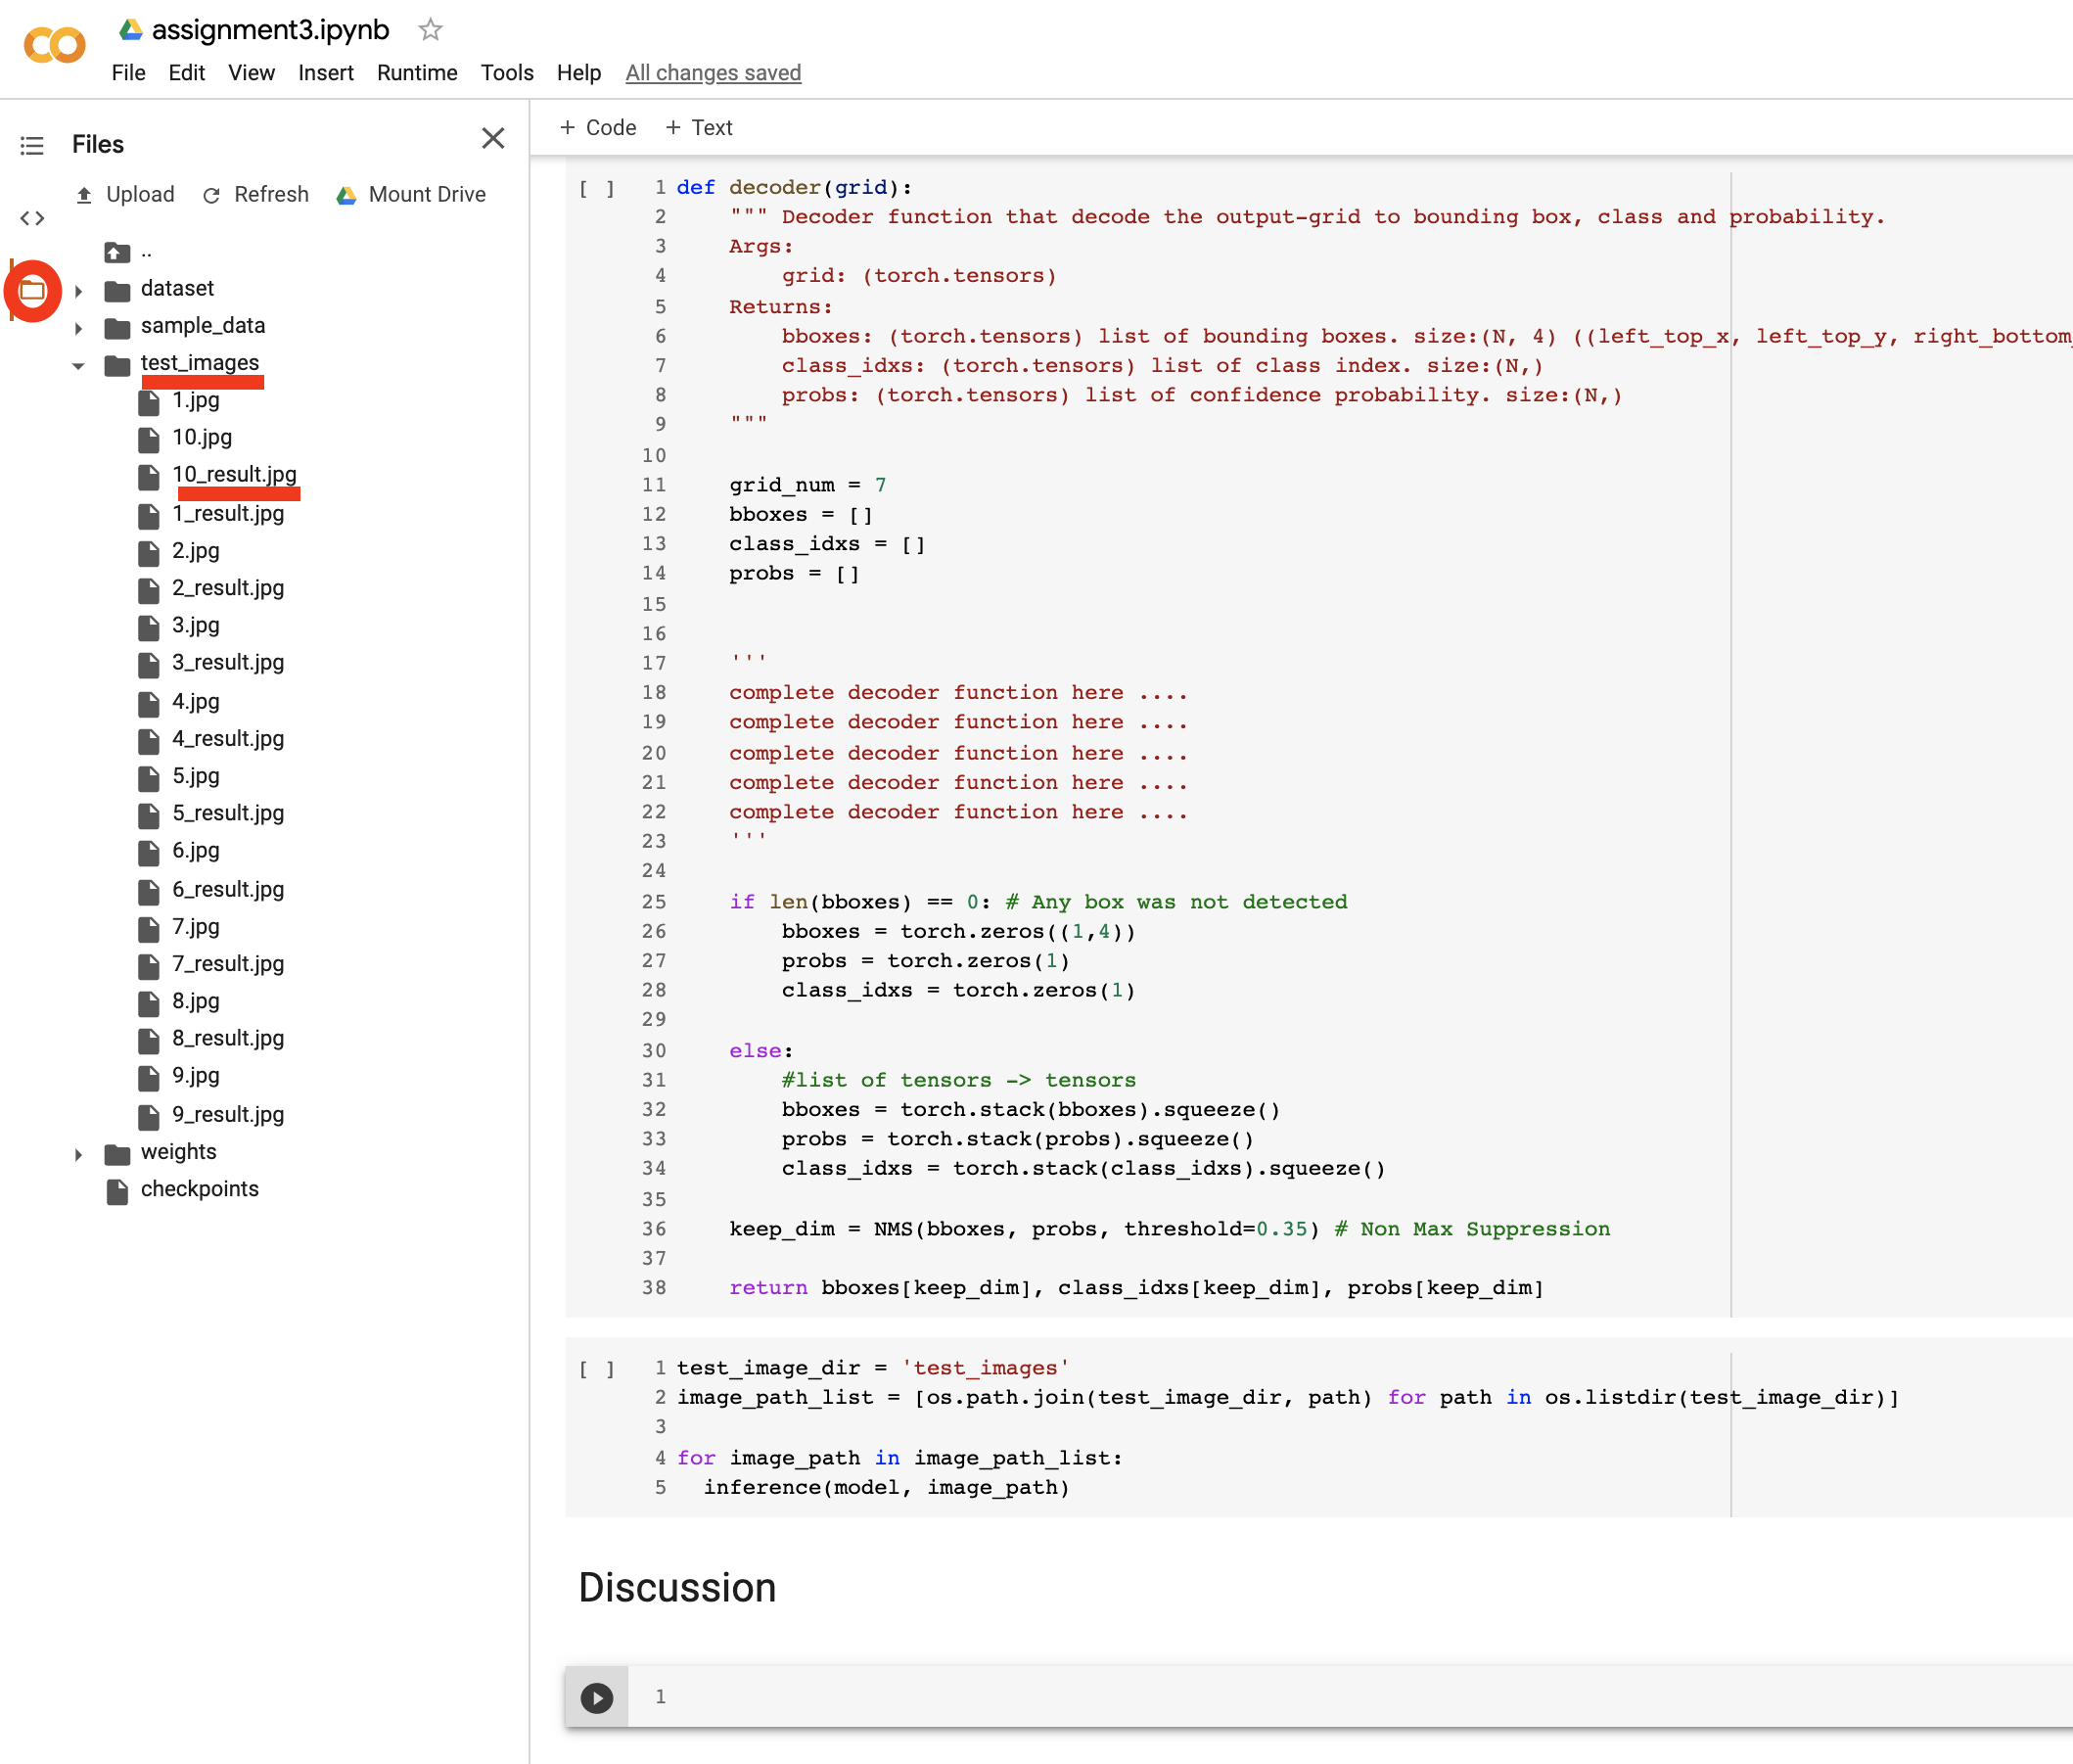

In [ ]:
VOC_CLASSES = (
    'aeroplane', 'bicycle', 'bird', 'boat',
    'bottle', 'bus', 'car', 'cat', 'chair',
    'cow', 'diningtable', 'dog', 'horse',
    'motorbike', 'person', 'pottedplant',
    'sheep', 'sofa', 'train', 'tvmonitor')

def NMS(bboxes, scores, threshold=0.35):
    ''' Non Max Suppression
    Args:
        bboxes: (torch.tensors) list of bounding boxes. size:(N, 4) ((left_top_x, left_top_y, right_bottom_x, right_bottom_y), (...))
        probs: (torch.tensors) list of confidence probability. size:(N,) 
        threshold: (float)   
    Returns:
        keep_dim: (torch.tensors)
    '''
    x1 = bboxes[:, 0]
    y1 = bboxes[:, 1]
    x2 = bboxes[:, 2]
    y2 = bboxes[:, 3]

    areas = (x2 - x1) * (y2 - y1)

    _, order = scores.sort(0, descending=True)
    keep = []
    while order.numel() > 0:
        try:
            i = order[0]
        except:
            i = order.item()
        keep.append(i)

        if order.numel() == 1: break

        xx1 = x1[order[1:]].clamp(min=x1[i].item())
        yy1 = y1[order[1:]].clamp(min=y1[i].item())
        xx2 = x2[order[1:]].clamp(max=x2[i].item())
        yy2 = y2[order[1:]].clamp(max=y2[i].item())

        w = (xx2 - xx1).clamp(min=0)
        h = (yy2 - yy1).clamp(min=0)
        inter = w * h

        ovr = inter / (areas[i] + areas[order[1:]] - inter)
        ids = (ovr <= threshold).nonzero().squeeze()
        if ids.numel() == 0:
            break
        order = order[ids + 1]
    keep_dim = torch.LongTensor(keep)
    return keep_dim

In [ ]:
def inference(model, image_path):
    """ Inference function
    Args:
        model: (nn.Module) Trained YOLO model.
        image_path: (str) Path for loading the image.
    """
    # load & pre-processing
    image_name = image_path.split('/')[-1]
    image = cv2.imread(image_path)

    h, w, c = image.shape
    img = cv2.resize(image, (224, 224))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    transform = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    img = transform(torch.from_numpy(img).float().div(255).transpose(2, 1).transpose(1, 0)) #Normalization
    img = img.unsqueeze(0)
    img = img.to(device)

    # inference
    output_grid = model(img).cpu()

    #### YOU SHOULD IMPLEMENT FOLLOWING decoder FUNCTION ####
    # decode the output grid to the detected bounding boxes, classes and probabilities.
    bboxes, class_idxs, probs = decoder(output_grid)
    num_bboxes = bboxes.size(0)

    # draw bounding boxes & class name
    for i in range(num_bboxes):
        bbox = bboxes[i]
        class_name = VOC_CLASSES[class_idxs[i]]
        prob = probs[i]

        x1, y1 = int(bbox[0] * w), int(bbox[1] * h)
        x2, y2 = int(bbox[2] * w), int(bbox[3] * h)

        cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)
        cv2.putText(image, '%s: %.2f'%(class_name, prob), (x1, y1), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 255), 1,
                    8)

    cv2.imwrite(image_name.replace('.jpg', '_result.jpg'), image)

In [ ]:
def decoder(grid):
    """ Decoder function that decode the output-grid to bounding box, class and probability. 
    Args:
        grid: (torch.tensors)
    Returns:
        bboxes: (torch.tensors) list of bounding boxes. size:(N, 4) ((left_top_x, left_top_y, right_bottom_x, right_bottom_y), (...))
        class_idxs: (torch.tensors) list of class index. size:(N,)
        probs: (torch.tensors) list of confidence probability. size:(N,)
    """

    grid_num = 7
    bboxes = []
    class_idxs = []
    probs = []

    # P4 Implement the decoder function

    # ----- Non Max Suppresion (NMS) function -----
    # Input:
    #   1) bboxes: (torch.tensors) list of bounding boxes. size:(N, 4) ((left_top_x, left_top_y, right_bottom_x, right_bottom_y), (...))
    #   2) probs: (torch.tensors) list of confidence probability. size:(N,) 
    #   3) threshold: (float) 
    # Output:
    #   4) keep_dim: (torch.tensors)    
    
    # We make above format because of input NMS function !!

    # ----- Process -----
    # 1) Analysis Grid Tensor: Output Size = torch.Size([1, 7, 7, 30]), 
    #                          30 = [5 * Bounding box Number + Class Number], where len(5) = [x, y, w, h, conf]
    # 2) Calculate Pr(Class|Object) = Pr(Class Score | each grid) * Confidence of each bounding box (Confidence = Pr(each grid) * IoU)
    #              : each grid has two bounding box information and 20 classes of VOC dataset
    #              : Total Number of tensors 7 * 7 * 2 * 20 = grid_x * grid_y * number of boxes * dataset classes = 98 * 20 (Not use all them! only using not zero values !!)
    # 3) If the probability is over 0.2, then save that bounding box information and append bboxes, class_idxs, probs !!
    #              : change format to calculate NMS function 
    #              : Bounding box format is [x, y, w, h] -> To change [x_left_top, y_left_top, x_right_bottom, y_right_bottom]

    # Grid Size is [1, 7, 7, 30] !! So, it should convert [1, 7, 7, 30] to [7, 7, 30] using squeeze which erase where dimension size is '1' !!
    grid = grid.squeeze(dim=0)
    
    for grid_x in range(grid_num):
        for grid_y in range(grid_num):
            # To find best value and index of class score in each grid
            best_class_value, best_class_index = torch.max(grid[grid_y, grid_x, 10:30], 0) 

            # To find probability class score of each bounding box in each grid
            bbox1_prof = grid[grid_y, grid_x, 4] * best_class_value # Output = torch.Size([1])
            bbox2_prof = grid[grid_y, grid_x, 9] * best_class_value # Output = torch.Size([1])

            # Convert bounding box format to aforementioned format like = [x, y, w, h] -> [x1, y1, x2, y2] in each grid !!!
            bbox1_LT_RB = torch.zeros(4) # Output = torch.Size([4])
            bbox2_LT_RB = torch.zeros(4) # Output = torch.Size([4])

            # Case Number
            # CASE == 1: There two bounding box probabilities are higher than 0.2. So, get two bounding box's information !!
            # CASE == 2: Only first bounding box probability is higher than 0.2. So, get first bounding box's information !!
            # CASE == 3: Only second bounding box probability is higher than 0.2. So, get second bounding box's information !!
            case = 0

            # Bounding Box result is left-top corner, so it must translate each bounding box position !!
            fit_xy_cell = torch.FloatTensor([grid_x, grid_y]) / float(grid_num)

            # The first case does not any process !! Because both bounding box probailities are higher than 0.2 !!
            if bbox1_prof < 0.2 and bbox2_prof < 0.2:
              continue
            elif bbox1_prof > 0.2 and bbox2_prof > 0.2:
              case = 1
              # Define [x1, y1, x2, y2] of bounding box1
              bbox1_LT_RB[0:2] = (grid[grid_y, grid_x, 0:2] / float(grid_num)) + fit_xy_cell - (0.5 * grid[grid_y, grid_x, 2:4])
              bbox1_LT_RB[2:4] = (grid[grid_y, grid_x, 0:2] / float(grid_num)) + fit_xy_cell + (0.5 * grid[grid_y, grid_x, 2:4]) 
              # Define [x1, y1, x2, y2] of bounding box2
              bbox2_LT_RB[0:2] = (grid[grid_y, grid_x, 5:7] / float(grid_num)) + fit_xy_cell - (0.5 * grid[grid_y, grid_x, 7:9]) 
              bbox2_LT_RB[2:4] = (grid[grid_y, grid_x, 5:7] / float(grid_num)) + fit_xy_cell + (0.5 * grid[grid_y, grid_x, 7:9]) 
            elif bbox1_prof > 0.2 and bbox2_prof < 0.2:
              case = 2 
              # Define [x1, y1, x2, y2] of bounding box1
              bbox1_LT_RB[0:2] = (grid[grid_y, grid_x, 0:2] / float(grid_num)) + fit_xy_cell - (0.5 * grid[grid_y, grid_x, 2:4])
              bbox1_LT_RB[2:4] = (grid[grid_y, grid_x, 0:2] / float(grid_num)) + fit_xy_cell + (0.5 * grid[grid_y, grid_x, 2:4]) 
            else:
              case = 3
              # Define [x1, y1, x2, y2] of bounding box2
              bbox2_LT_RB[0:2] = (grid[grid_y, grid_x, 5:7] / float(grid_num)) + fit_xy_cell - (0.5 * grid[grid_y, grid_x, 7:9])
              bbox2_LT_RB[2:4] = (grid[grid_y, grid_x, 5:7] / float(grid_num)) + fit_xy_cell + (0.5 * grid[grid_y, grid_x, 7:9]) 

            if case == 1:
              bboxes.append(bbox1_LT_RB)
              bboxes.append(bbox2_LT_RB)
              class_idxs.append(best_class_index)
              class_idxs.append(best_class_index)
              probs.append(bbox1_prof)
              probs.append(bbox2_prof)
            elif case == 2:
              bboxes.append(bbox1_LT_RB)
              class_idxs.append(best_class_index)
              probs.append(bbox1_prof)
            elif case == 3:
              bboxes.append(bbox2_LT_RB)
              class_idxs.append(best_class_index)
              probs.append(bbox2_prof)

    if len(bboxes) == 0: # Any box was not detected
        bboxes = torch.zeros((1,4))
        probs = torch.zeros(1)
        class_idxs = torch.zeros(1, dtype=torch.int)             # for bugs I changed
        
    else: 
        # list of tensors -> tensors
        ## for bugs I changed ##
        # bboxes = torch.cat(bboxes, dim=0)
        # probs = torch.cat(probs, dim=0)
        # class_idxs = torch.cat(class_idxs, dim=0)

        ##### [IMPORTANT !!!] #####
        ##### An error occurred about changing the shape of the variables corresponding to the scalar list whose size is ([1,]) above, so change them all as follows!!!! 
        bboxes = torch.stack(bboxes, dim=0)
        probs = torch.stack(probs, dim=0)
        class_idxs = torch.stack(class_idxs, dim=0)

    # Modified version : It applies nms class by class. 
    bboxes_result, class_idxs_result, probs_result = [], [], []
    for label in range(num_classes):
        label_mask = (class_idxs==label)
        if label_mask.sum() > 0:
            _bboxes = bboxes[label_mask]
            _probs = probs[label_mask]
            _class_idxs = class_idxs[label_mask]
            
            keep_dim = NMS(_bboxes, _probs, threshold=0.16) # Non Max Suppression
            bboxes_result.append(_bboxes[keep_dim])
            class_idxs_result.append(_class_idxs[keep_dim])
            probs_result.append(_probs[keep_dim])

    bboxes_result = torch.cat(bboxes_result, 0)
    class_idxs_result = torch.cat(class_idxs_result, 0)
    probs_result = torch.cat(probs_result, 0)

    return bboxes_result, class_idxs_result, probs_result

    # # Original Code.     
    # keep_dim = NMS(bboxes, probs, threshold=0.16) # Non Max Suppression

    # return bboxes[keep_dim], class_idxs[keep_dim], probs[keep_dim]

In [ ]:
test_image_dir = './test_images/'
image_path_list = [os.path.join(test_image_dir, path) for path in os.listdir(test_image_dir)]
model.eval()

for image_path in image_path_list:
  inference(model, image_path)

# Discussion (15pt)
In this section, you should summarize your results with your analysis on them. Since implementation of YOLO is already dense, you don't need to conduct your own experiments this time. Instead, provide a disucssion on YOLO. At least, your discussion must include following items.
* Provide at least 3 result images (`1_image.jpg`, `2_image.jpg`, ...) and brief analysis on them (If it's working well, discuss the key to the success. If it's not working properly, discuss the possible reasons for the failure.) 
* Analysis on why YOLO works so fast compared to its competitors (eg, RCNN, Fast-RCNN, Faster-RCNN). 

---
# **Results**
---
---
- **1_reuslt.jpg**

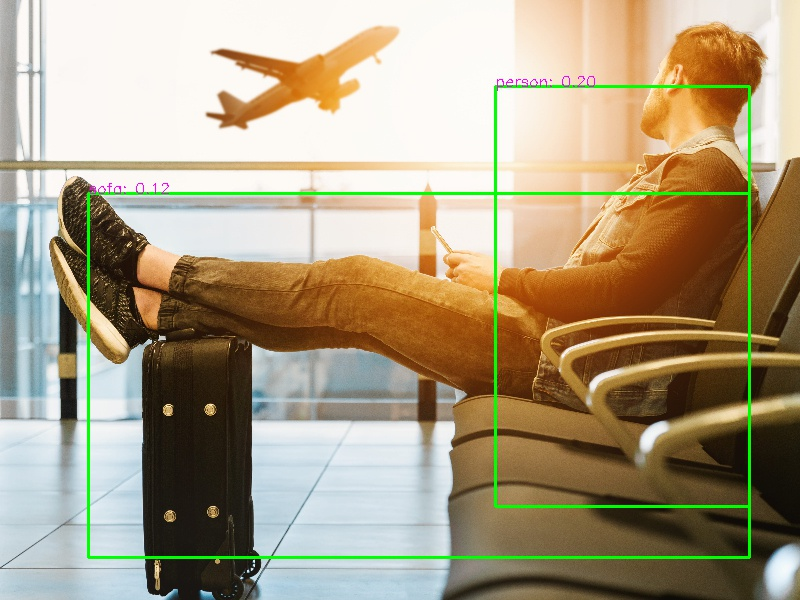

---
- **2_reuslt.jpg**

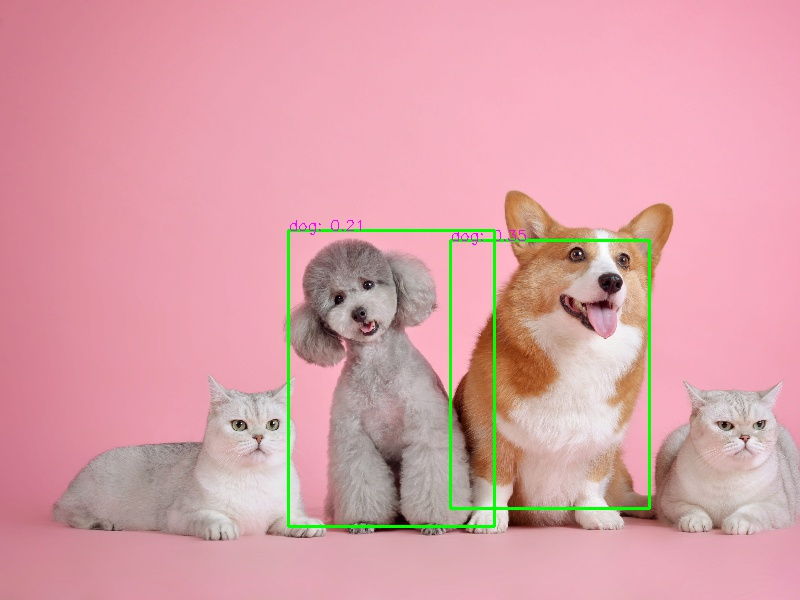

---
- **3_reuslt.jpg**

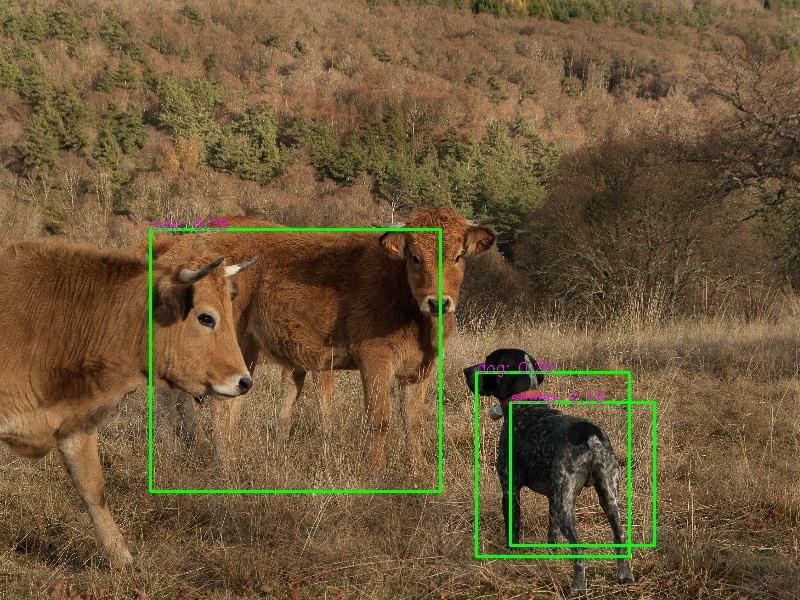

---
- **4_reuslt.jpg**

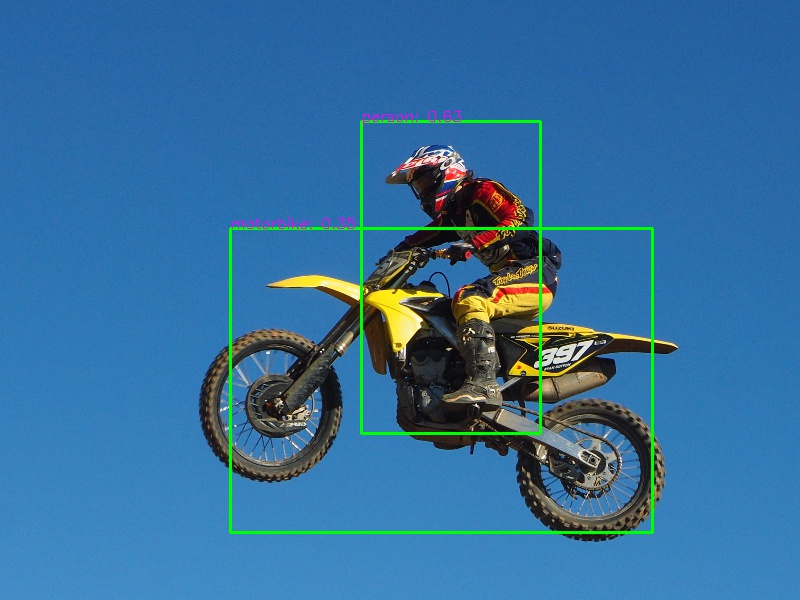

---
- **5_reuslt.jpg**

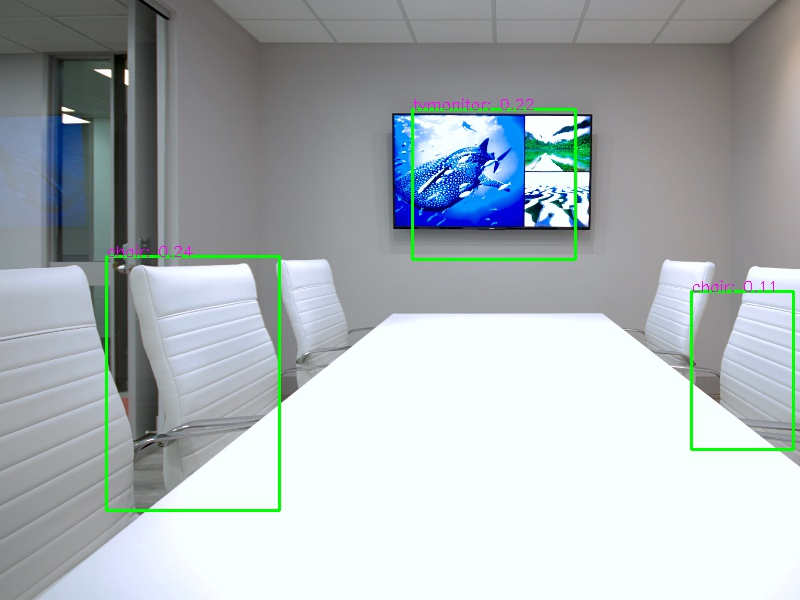

---
- **6_reuslt.jpg**

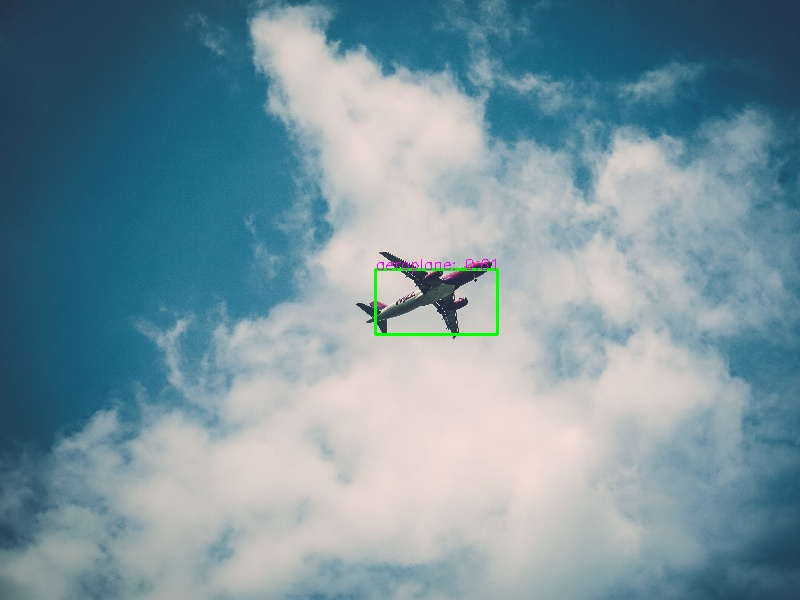

---
- **7_reuslt.jpg**

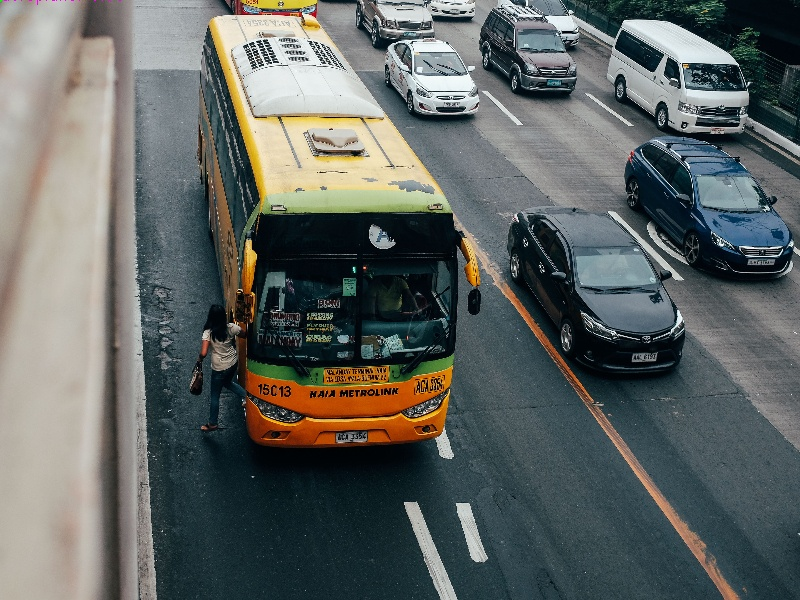

---
- **8_reuslt.jpg**

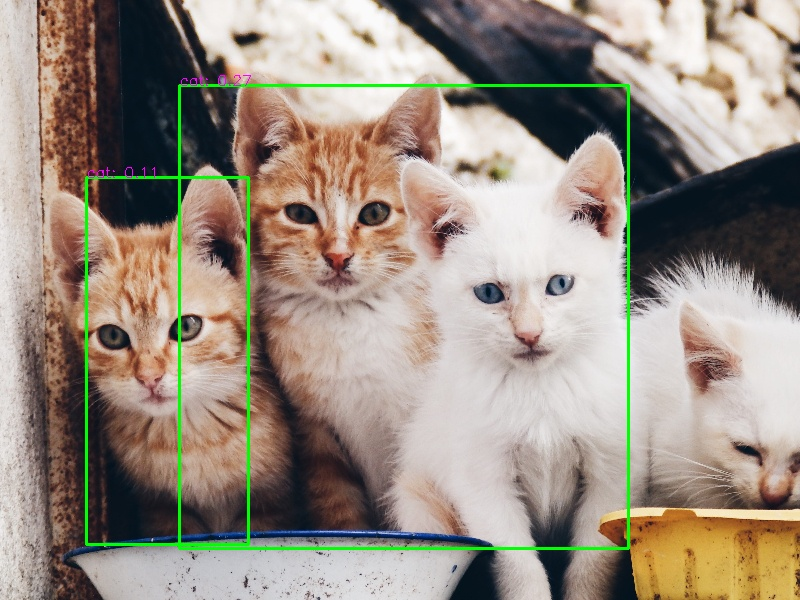

---
- **9_reuslt.jpg**

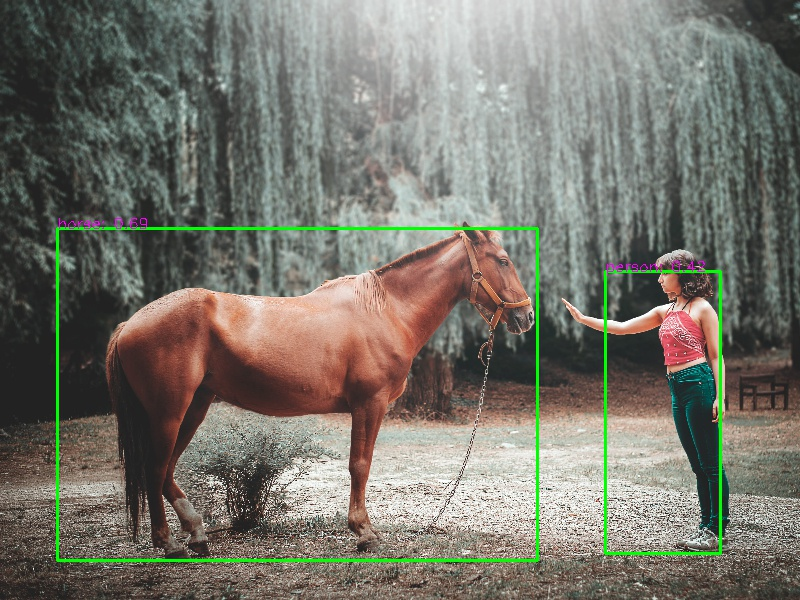

---
- **10_reuslt.jpg**

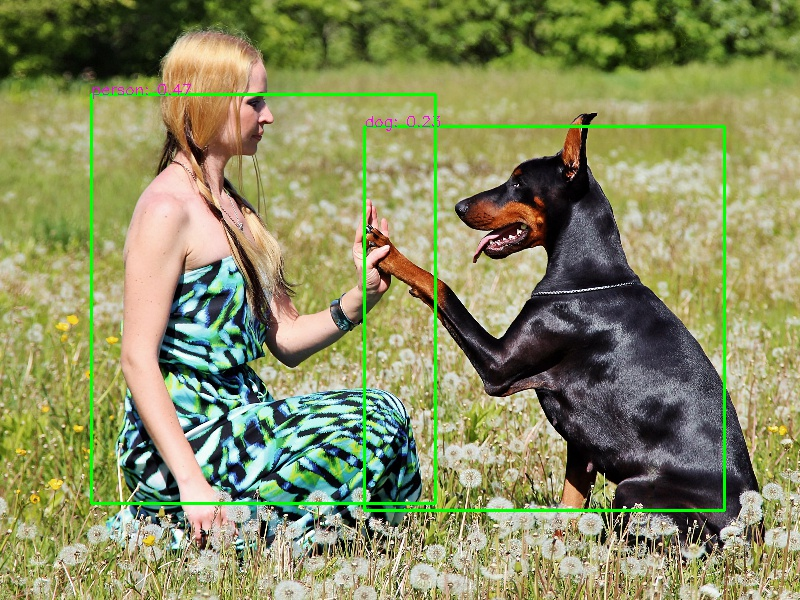

---

---
# **Discussion about the above Experiments !!**
---
---
**Method of improvement training time in Problem 2 (Implement Loss Function) !!** 

* The training time for one batch size in **method 1** is about **about 26 seconds**. Then, it takes 8320 seconds to run one epoch, which takes about 138 minutes. The reason is that the methodology I used brought the size of pred_tensor and target_tensor as it is and used the tensor. That is, there were many values ('0') that were not necessary to calculate the loss. The shape of target_tensor & pred_tensor has **[64, 7, 7, 30] = 94080 parameters**. For example, among them, there were only about [113, 30] = 3390 shapes of obj_tensor. Since the remaining values are dummy values, we did not need to use them, but we added them to the operation. So it took a very long time.

* In **"Method 2"**, the training time for one batch size is about **about 0.95 seconds**. Then, it takes 304 seconds to run one epoch, which takes about 5.1 minutes. The reason is that all dummy values used in **"Method 1"** have been removed. And the operation of **".cuda()"**, which is the act of moving the cpu operation to the gpu operation, was applied only to the variables that actually calculate the loss. This is because the act of transferring computation from the CPU to the GPU also affects time consumption. Finally, time consumption is reduced by using the method of directly acquiring values using boolean values rather than operating through a for loop. Changing them saved a lot of time, and the biggest impact was the removal of dummy data that was not used for calculations.

---
**Provide at least 3 result images (`1_image.jpg`, `2_image.jpg`, ...) and brief analysis on them (If it's working well, discuss the key to the success. If it's not working properly, discuss the possible reasons for the failure.)**

* Images extracted correctly: **2_result.jpg, 4_result.jpg, 5_result.jpg, 6_result.jpg, 8_result.jpg, 9_result.jpg, 10_result.jpg**

* Images not extracted correctly: **1_result.jpg, 3_result.jpg, 7_result.jpg**

The reasons why object detection does not proceed well are as follows. First of all, in the case of 1_result.jpg, I think there is a problem of geometry learning for sofa. In general, in the case of sofa, it has the shape of a rectangle with a long horizontal size, and as CNN learns it, it can predict such long objects as sofa. That is, looking at the result of lowering the threshold value of bounding box probability to 0.05, if the width is wide in 1_result.jpg and 5_result.jpg, there is a problem of detecting a sofa. Therefore, I think there is a problem with the geometry of the learning sofa.

* **1_result.jpg & 5_result.jpg predict "sofa"**
  - **5_result.jpg with 0.05 threshold of box probability !!**
    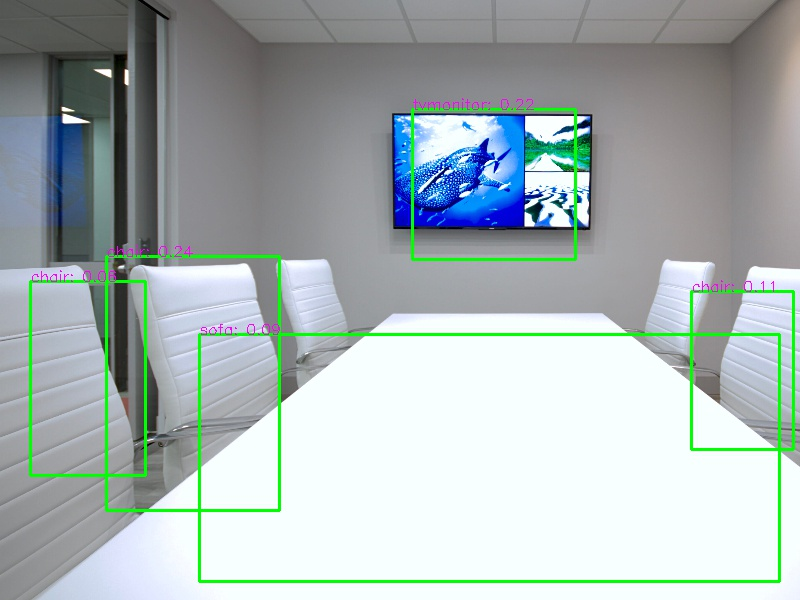

Second, in the case of 3_result.jpg, the body part except for the dog's head was predicted as sheep, and it can be seen that this is similar to the sheep's geometry. As you can see in the test image, if you look closely at the dog's torso, you can see that it looks very similar to the sheep's wool with the human eye. Therefore, it can be seen that this also made an erroneous prediction in the process of detection during the learning process.

Finally, it is 7_result.jpg, and in this case, it was confirmed that no detection was made. There are many reasons for this, but the first is that the size of the object at the back is very small. Since they are very small, it is difficult to accurately calculate the IoU between bounding boxes. Therefore, their loss function also has poor results. Second, since there are cases where there are several cars in one grid, two objects cannot be detected in one grid, so it was not possible to detect a car. Lastly, even when cars overlap, it cannot be predicted properly, but there is a disadvantage that classification cannot be performed on objects cut in the middle. Based on these causes, the loss function is affected, and finally, IoU is not calculated correctly, making prediction of the image difficult.

---
**Analysis on why YOLO works so fast compared to its competitors (eg, RCNN, Fast-RCNN, Faster-RCNN)** 

* The overall process for general object detection is **"Region Extraction -> Feature Extraction -> Classification -> Post-processing"**. In the traditional method, all of these processes were hand-designed, and their performance did not show such good performance. That is, the features extracted by hand design were not robust, nor did we robustly classify a lot of apperance variations.

* **[R-CNN]** R-CNN is the method of extracting the feature extraction step based on CNN in the traditional method. This model proceeds with a region of interest (RoI) using a sliding window method. And through this, about 2000 bounding boxes are extracted. After that, resize to put it as input of CNN. The features resulting from CNN are classified using SVM (Support Vector Machine). Additionally, if the bounding boxes, which are detection results, have bias or errors, post-processing is performed to move them to the correct object with a slight shift. However, this model consumes a lot of time because it has a lot more parameters than the method extracted by hand design and calculates a lot of parameters for all images. There are other score maps in region proposals as well, which consumes a lot of time to compute. And because the CNN, which has not been fine-tuned, was applied only to the feature extraction part, not in an end-to-end manner (the train process for SVM and the train process for feature extraction are separated), there was a limit in performance.

* **[Fast-RCNN]** We proposed a method to improve speed and training, which are disadvantages of R-CNN. In other words, Fast-RCNN proposed a feature extraction methodology, an improvement in the operation speed of region proposal operation, and an end-to-end method in the existing R-CNN method. First, in order to remove the RoI operation, we performed feature extraction by taking CNNs for the entire image. This has the advantage of having spatial resolution of the image. Then, RoI was performed using the features obtained in the entire image. And to acquire region information, global pooling was performed to acquire information. After that, classification and post-processing were performed using a fully connected layer. Finally, learning was carried out in an end-to-end method by combining the loss of classification obtained through softmax and loss obtained through bounding box regression. Since the whole was changed to CNN, the time was reduced. In addition, the speed was improved by configuring the network for training into one stage and one network. However, the process of still calculating RoI does not consist of a network and affects the operation speed. Also, although the overall end-to-end manner is correct, it seems a bit unreasonable to view it as a perfect end-to-end manner.

* **[Faster-RCNN]** In order to solve the problem of Fast-RCNN, the RoI part also applied the network to finally configure the end-to-end method perfectly. Here, there are 4 pieces of information [center_x, center_y, width, height] of the bounding box, and their scores are included. After obtaining the regression loss for the box, and the classification loss, pooling proceeds, and enters the classification stage. So, finally, region extraction (Faster-RCNN) + feature extraction (RCNN, SPPNet) + classification (Fast-RCNN) were completed in the traditional method. However, their speed did not exceed 30 fps and 60 fps, which are frames per second (fps) of general video. The reason is that their models RCNN & Fast-RCNN & Faster-RCNN are not composed of a single network but are composed of several CNN-based networks, so their speed has limitations compared to YOLO.

* **[YOLO]** YOLO designed the object detector to be very simple. And it is an algorithm that proceeds all the way to object detection with one network. The overall network structure is designed like the FCN structure. This is a network composed of all convolutional layers with the fully connected layer removed. Using the object score and confidence score of the tensor that passed Fully Connected Network(FCN), it predicts the same role and bounding box as the RoI algorithm and also predicts the class. However, class prediction and bounding boxes are processed in parallel and finally concatenated to proceed with object detection. Therefore, in the end, the reason why it is faster than the above-mentioned models is that all processes can be performed with one network at once. In fact, if you look at the time, it boasts a speed of **about 45 fps** and shows not bad results. However, there are still problems here. There is a problem that only one class can be detected on one grid, and there are disadvantages that it is difficult to predict easily for very small objects or overlap.

---